<a href="https://colab.research.google.com/github/Erhtric/NeuralQuestionGenerationNLP/blob/master/goqu_nb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**[WIP]** This is the main file: its purpouse is to collect all the code coming from the coding pipeline.

# GoQU (Generator of QUestions): a tensorflow implementation of the "Learning to Ask" paper

The paper cited is [Learning to Ask: Neural Question Generation for Reading Comprehension](https://aclanthology.org/P17-1123) (Du et al., ACL 2017)

This section contains initializations, various configurations and libraries importing.

# 0. Libraries

The requirements are all included in the `requirements.txt` file present in the root directory of this project. The additional requirements required for colab will be downloaded in the next cell.

In [1]:
try:
  import google.colab
  IN_COLAB = True
  %%capture
  %pip install datasets
  %pip install keras-tuner --upgrade
  %pip install rouge_score
  # %pip install tflearn - batchnorm

  from google.colab import drive
  drive.mount('/content/drive')
except:
  IN_COLAB = False

In [2]:
# %load_ext tensorboard
%load_ext autoreload
%autoreload 2

import os
import json
import sys
sys.path.append(".")
sys.path.append("..")

import tensorflow as tf
import numpy as np
import pandas as pd
# disable chained assignments to avoid annoying warning
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import datetime
import tensorflow as tf
from tensorflow import keras

from typing import Any, Tuple, List, NamedTuple

# Dataloader & Configs
from src.data.data_generator import SQuAD, Dataset
from configs.config import *

# Embeddings
from src.utils.embeddings import GloVe

# Model
from src.models.layers import Encoder, Decoder, CustomMasking
from src.models.loss import MaskedLoss
from src.models.trainers.metrics import Perplexity, MaskedAccuracy
from src.models.callbacks import BatchLogs, CustomLearningRateScheduler, GetEpochNumber

c:\Users\ericr\anaconda3\envs\nqg\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Commands to prepare the folder to accomodate data, this may be specific to each individual project.

In [3]:
if not os.path.exists('./data'):
  print('Data folder does not exists. Creating it')
  os.makedirs('./data', exist_ok=True)

if not os.path.exists('./training_checkpoints'):
  print('Training checkpoint folder does not exists. Creating it')
  os.makedirs('./training_checkpoints', exist_ok=True)

if not os.path.exists('./logs'):
  print('Tensorboard Logs folder does not exists. Creating it')
  os.makedirs('./logs', exist_ok=True)

# 1. Dataset Definition

Here we implement a dataset-utility class that:
1. loads the dataset `.json` file and converts it to a `pandas.DataFrame` file, saves it to a `Pickle` file,
2. extract the sentence that contains the answer from the context of each sample,
3. preprocess the dataset by:
    - clean the sentences by removing special characters and punctuactions,
    - add to each sentence, both for the question and the context, $x$ a start of sequence `<SOS>` tag and end of sequence `<EOS>` tag,
4. split the dataset according to the partitions defined in the configuration file,
5. tokenize each sentence and pad them to the a specified max length, computed in order to cover about 99% of the dataset phrases' length,
6. Pad each context to maximum length.

The resulting data that will be used hereinafter will be of type `tf.data.Dataset`. By calling the `SQuAD` constructor we create a dataset handling object which will be useful for future operations.

This is the data produced that we are most interested in. As we can see we will have:
- a data structure `dataset` containing the training, validation and test set;
- a tuple containing the word-to-token mappings for the training, validation and test set respectively.

Note that loading the dataset will require some time.

In [4]:
# Preprocessed dataset without tokenizing
# %%time
dataset_creator = SQuAD()
dataset, word_to_idx_context, word_to_idx_question = dataset_creator(dataset_config, path_config, tokenized=True)

# max_length_context = dataset_creator.max_length_context
# max_length_question = dataset_creator.max_length_question

model_config["max_length_context"] = dataset.train.element_spec[0].shape[1]
model_config["max_length_question"] = dataset.train.element_spec[1].shape[1]

print(f'Sentences max lenght: {model_config["max_length_context"]}')
print(f'Questions max lenght: {model_config["max_length_question"]}')

File already exists! Loading from .pkl...

Dir path ./data/squadv1.1.pkl
Sentences max lenght: 102
Questions max lenght: 27


Accessing such `NamedTuple` data structure (cfr `dataset`) is pretty simple, namely in a:
1. tuple-way by accessing it like a list, e.g. `train = dataset[0]`,
2. object-way by calling the instance parameters, e.g. `train = dataset.train`.

The other two returned values are the word to index mappings for the context and question words respectively. In order to refer to a specific split simply call:
1. for the training dataset,
2. for the validation dataset,
3. for the test dataset.

We can see how the dataset is distributed, we have chosen to give 65% to the training set, about 20% to the validation and the remaining 15% to the test set.

In [5]:
num_samples_train = dataset.train.cardinality().numpy() * dataset_config['batch_size']
num_samples_val = dataset.val.cardinality().numpy() * dataset_config['batch_size']
num_samples_test = dataset.test.cardinality().numpy() * dataset_config['batch_size']

print(f'Num samples --- [Train]: {num_samples_train} [Validation]: {num_samples_val} [Test]: {num_samples_test}')

Num samples --- [Train]: 58336 [Validation]: 17280 [Test]: 11936


In [6]:
print(f'Training vocab size for the context: {len(word_to_idx_context[0])}')
print(f'Training vocab size for the question: {len(word_to_idx_question[0])}')
print()
print(f'Validation vocab size for the context: {len(word_to_idx_context[1])}')
print(f'Validation vocab size for the question: {len(word_to_idx_question[1])}')
print()
print(f'Test vocab size for the context: {len(word_to_idx_context[2])}')
print(f'Test vocab size for the question: {len(word_to_idx_question[2])}')

Training vocab size for the context: 52628
Training vocab size for the question: 29191

Validation vocab size for the context: 60390
Validation vocab size for the question: 33660

Test vocab size for the context: 60390
Test vocab size for the question: 33660


Note that the vocabularies for the test set are not updated this is because we want to simulate how it handles tasks in the real world.

In [7]:
print(f'Vocab size --- [Context]: {len(word_to_idx_context[1])} [Question]: {len(word_to_idx_question[1])}')

Vocab size --- [Context]: 60390 [Question]: 33660


Here below we report a simple analysis on the length of the sentences, but keep in mind that all the computations are done in the `SQuAD` class which handles the padding length accordingly.

In [8]:
context_list = list(dataset_creator.preproc_squad_df.context)
question_list = list(dataset_creator.preproc_squad_df.question)

context_length = [len(sen.split()) for sen in context_list]
question_length = [len(sen.split()) for sen in question_list]

print("Lenght of longest sentence in the context: {}".format(np.max(context_length)))
print("Mean length in for sentences in the context: {}\n".format(np.mean(context_length)))

print("Lenght of longest sentence in the question: {}".format(np.max(question_length)))
print("Mean length in for sentences in the question: {}\n".format(np.mean(question_length)))

Lenght of longest sentence in the context: 389
Mean length in for sentences in the context: 33.75989451934383

Lenght of longest sentence in the question: 62
Mean length in for sentences in the question: 13.322275368440279



# 2. GloVe and Embeddings

In order to represent terms we choose to use pre-trained GloVe embeddings. Along the same path, we also provide a method to build the embedding matrices. To represent Out-Of_Vocabulary words we will use vectors randomly sampled from the interval $[-\frac{1}{2}, \frac{1}{2}]$ of fixed size $d$. In this experiment we set the embedding dimension $d=300$.

The next step is to initialize the handler with the desidered `embedding_dimension`. Then to build the embedding matrix with the pre-trained GloVe embeddings simply call the `build_embedding_matrix` method.

In [9]:
%%time
# Initalize the handler for GloVe
glove_handler = GloVe(embedding_dimension=300)

# We will create the matrix by using only the words present in the training and validation set
embedding_matrix_context, oov_words_context = glove_handler.build_embedding_matrix(
    word_to_idx_context[2],
    len(word_to_idx_context[2]))

embedding_matrix_question, oov_words_question = glove_handler.build_embedding_matrix(
    word_to_idx_question[2],
    len(word_to_idx_question[2]))

100%|██████████| 33660/33660 [00:00<00:00, 104309.33it/s]

CPU times: total: 734 ms
Wall time: 1.36 s


Convert both of them into tensor, but it is fine to also treat them as `numpy` array, still it is better to use the `tensorflow` fundamentals. We also check the shapes, but this step is not fundamental.

In [10]:
embedding_matrix_context = tf.convert_to_tensor(embedding_matrix_context)
embedding_matrix_question = tf.convert_to_tensor(embedding_matrix_question)

print(f'Embedding matrix for the context: {embedding_matrix_context.shape}')
print(f'Embedding matrix for the question: {embedding_matrix_question.shape}')

Embedding matrix for the context: (60390, 300)
Embedding matrix for the question: (33660, 300)


# 3. Encoder-Decoder Definition

Here comes a fundamental step in our experiment: the model defintion. Before proceeding we have to build the two main components of such model, which it resembles the Seq2Seq model presented in [Sequence to Sequence Learning with Neural Networks](https://arxiv.org/abs/1409.3215) (Sutskever et al., 2014), that are:
1. the **Encoder**, that it creates a representation of the input context, in our case the sentence containing the answers,
2. the **Decoder**, that tries to create a sentence given the representation provided by the Encoder by comparing the predictions it creates with an input sentence, that is our question.

In this section, not only we provide a way to define such models but also some testing pipelines in order to get the just mentioned idea.

In [11]:
example_context_batch, example_question_batch = next(iter(dataset.train))

## 3.1 Encoder
We will use a bidirectional LSTM to encode the sentence,
$$
\begin{align*}
\overrightarrow{b_t} &= \overrightarrow{\text{LSTM}}(x_t, \overrightarrow{b_{t-1}})\\
\overleftarrow{b_t} &= \overleftarrow{\text{LSTM}}(x_t, \overleftarrow{b_{t+1}})\\
\end{align*}
$$
where $\overrightarrow{b_t}$ is the hidden state at time step $t$ for the forward pass LSTM and $\overleftarrow{b_t}$ for the backward pass. In order to be able to pass it to the Decoder object we contenate the two hidden state produced by the two LSTMs. Here below we build an Encoder Model/Layer by exploiting the [Functional API](https://www.tensorflow.org/guide/keras/functional) by Keras.

See `src.models.encoder` for more details.

### 3.1.1 Test the encoder stack

Just like we have mentioned before this subsection serves only the purpose of testing the implemented class and checking if all the shapes makes some sense at the end. Firstly we define a model configuration object that will handle the hyperparameters of the Encoder model.

A simple example could be done by taking a single batch from the dataset, that is
$$
    X_{enc} = \text{Encoder}(X)
$$
where $X \in \mathbb{R}^{B \times M_c}$ is a batch of $B$ sentences long $M_c$ containg an answer to a respective question. The returned vector $X_{enc} \in \mathbb{R}^{B \times M_c \times U}$ is a batch of $B$ sentences long $M_c$, each of them encoded in a vector of size $U$. As a bi-product of using a Bi-LSTM we will also return the concatenated hidden and cell states $h$ and $c$ produced at the end.

In [18]:
# We need to encode the context, so we will pass the embedding matrix for the context
encoder = Encoder(model_config=model_config, embedding_matrix=embedding_matrix_context)
encoder_outputs, encoder_state = encoder(example_context_batch)

hidden_state, cell_state = encoder_state

print(f'Encoder output shape: (batch_size, max_length_context, units): {encoder_outputs.shape}')
print(f'Hidden state shape: (batch_size, units): {hidden_state.shape}')
print(f'Cell state shape: (batch_size, units): {cell_state.shape}')

Encoder output shape: (batch_size, max_length_context, units): (32, 102, 256)
Hidden state shape: (batch_size, units): (32, 256)
Cell state shape: (batch_size, units): (32, 256)


In [19]:
encoder.build_graph()       # TODO: does not work
encoder.summary()

Model: "encoder_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Context_embedding (Embeddin  (64, 102, 300)           18117000  
 g)                                                              
                                                                 
 spatial_dropout1d_1 (Spatia  (64, 102, 300)           0         
 lDropout1D)                                                     
                                                                 
 Context_encoding (Bidirecti  [(64, 102, 256),         439296    
 onal)                        (64, 128),                         
                              (64, 128),                         
                              (64, 128),                         
                              (64, 128)]                         
                                                                 
 Merge (Concatenate)         (64, 256)                 0 

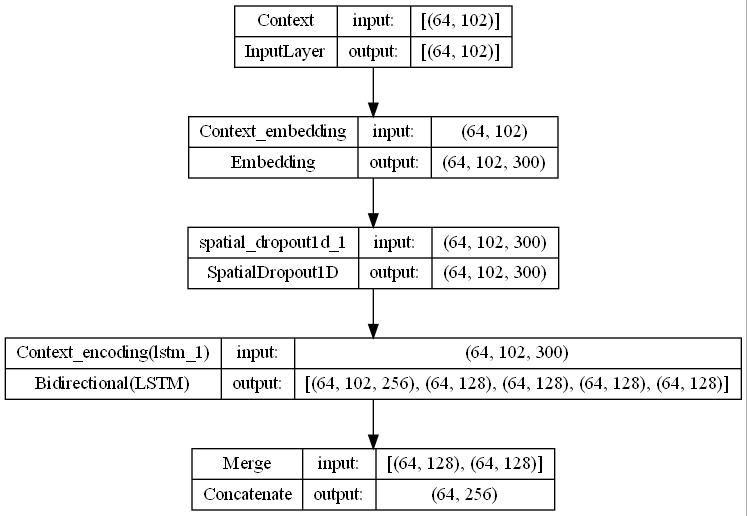

In [21]:
encoder.plot_model()

The encoder returns its internal state so that its state can be used to initialize the decoder. It's also common for a LSTM to return its state so that it can process a sequence over multiple calls.

## 3.2 Decoder

The encoder is structured in a different way since it has to generate predictions for the next output token:
1. the decoder uses an LSTM to process the questions and it is initialised with the encoder state,
2. the encoder output is used as a *query* to the attention head and as the *key* the sentence processed by the LSTM, this will produce a context vector and the attention weights,
3. the last hidden state and the context vector will be concatenated to produce the **attention vector**,
4. generating the logit predictions for the next token time step:
$$
    a_t = f(c_t, h_t) = W_s(\text{tanh}(W_c[c_t;h_t]))
$$

The model class is implemented in `src.models.layers.decoder`.

### 3.2.1 Test the decoder stack

The decoder will take as input:
1. `new_tokens`: the last token generated of shape `(batch_size, 1)`, namely the token obrained in the previous time step of the decoder (we will initialize the decoder with the `"<sos>"` token);
2. `enc_output`: this is the representation produced by the `Encoder` of shape `(batch_size, max_length_context, enc_units)`;
4. `decoder_state`: the previous state of the decoder, namely the internal state of the decoder's LSTM (the paper suggests to input the hidden and cell state produced by the Bi-LSTM). The shape is `[(batch_size, enc_units), (batch_size, enc_units)]`.

In [24]:
decoder = Decoder(model_config=model_config, embedding_matrix=embedding_matrix_question)

# Convert the target sequence, and collect the "[START]" tokens
start_tag_index = word_to_idx_question[2]['<sos>']
first_token = tf.constant([[start_tag_index]] * dataset_config['batch_size'])

decoder_logits, attention_weights, decoder_state = decoder(new_token=first_token, enc_output=encoder_outputs, state=encoder_state)

hidden_dec_state, cell_dec_state = decoder_state

print(f'Logits shape: (batch_size, t, output_vocab_size) {decoder_logits.shape}')
print(f'Attention weights shape: (batch_size, t, max_length_context) {attention_weights.shape}')
print(f'Hidden state shape: (batch_size, dec_units) {hidden_dec_state.shape}')
print(f'Cell state shape: (batch_size, dec_units) {cell_dec_state.shape}')

Logits shape: (batch_size, t, output_vocab_size) (32, 1, 33660)
Attention weights shape: (batch_size, t, max_length_context) (32, 1, 102)
Hidden state shape: (batch_size, dec_units) (32, 256)
Cell state shape: (batch_size, dec_units) (32, 256)


In [25]:
decoder.build_graph()
decoder.summary()

Model: "decoder_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Question_embedding (Embeddi  (64, 1, 300)             10098000  
 ng)                                                             
                                                                 
 Decoding_question_1 (LSTM)  [(64, 1, 256),            570368    
                              (64, 256),                         
                              (64, 256)]                         
                                                                 
 Decoding_question_2 (LSTM)  [(64, 1, 256),            525312    
                              (64, 256),                         
                              (64, 256)]                         
                                                                 
 Attention_head (AdditiveAtt  ((64, 1, 256),           256       
 ention)                      (64, 1, 102))              

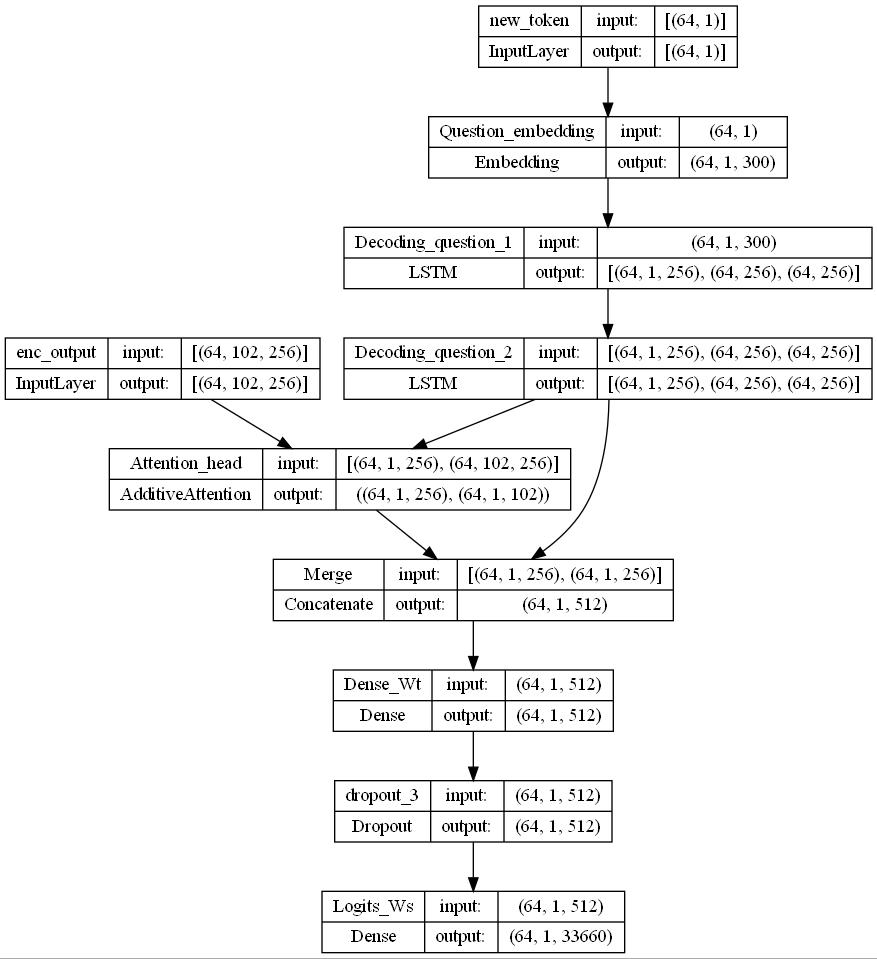

In [27]:
decoder.plot_model()

Moving on: this means that the decoder will produce a vector of unnormalized log probabilities (**logits**) associated to each vocabulary word. That is, a vector of logits $a_b \in \mathbb{R}^{\mathcal{V}}$ for each element $b$ in the batch, namely indicating the next probable token for a given sentence. 

Now we sample a token according to the logits computed by the decoder.

In [27]:
sampled_tokens = tf.random.categorical(
    logits=decoder_logits[:, 0, :],
    num_samples=1,
    seed=dataset_config['random_seed'])
vocab = np.array(list(word_to_idx_question[2].keys()))

first_word = list(vocab[tf.squeeze(sampled_tokens, axis=-1).numpy()])
first_word[:5]

['moor', 'uninominal', 'woolf', 'saftey', 'narrower']

We run it in order to produce another token, based on the previous predictions.

In [28]:
decoder_logits, _, _ = decoder([sampled_tokens, encoder_outputs], state=decoder_state)

sampled_tokens = tf.random.categorical(
    logits=decoder_logits[:, 0, :],
    num_samples=1,
    seed=dataset_config['random_seed'])
sampled_tokens = tf.squeeze(sampled_tokens, axis=-1).numpy()

first_word = list(vocab[sampled_tokens])
first_word[:5]

['nutrition', 'torriti', 'okay', 'blind', 'plasa']

Let's visualize the weights.

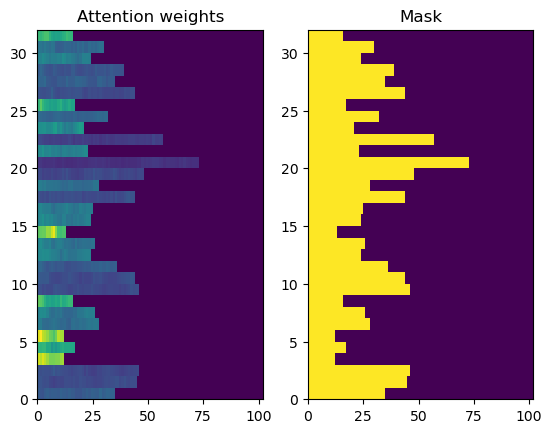

In [29]:
plt.subplot(1, 2, 1)
plt.pcolormesh(attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_context_batch != 0)
plt.title('Mask')
plt.show()

Let's visualize the weights for only one sequence.

<Figure size 640x480 with 0 Axes>

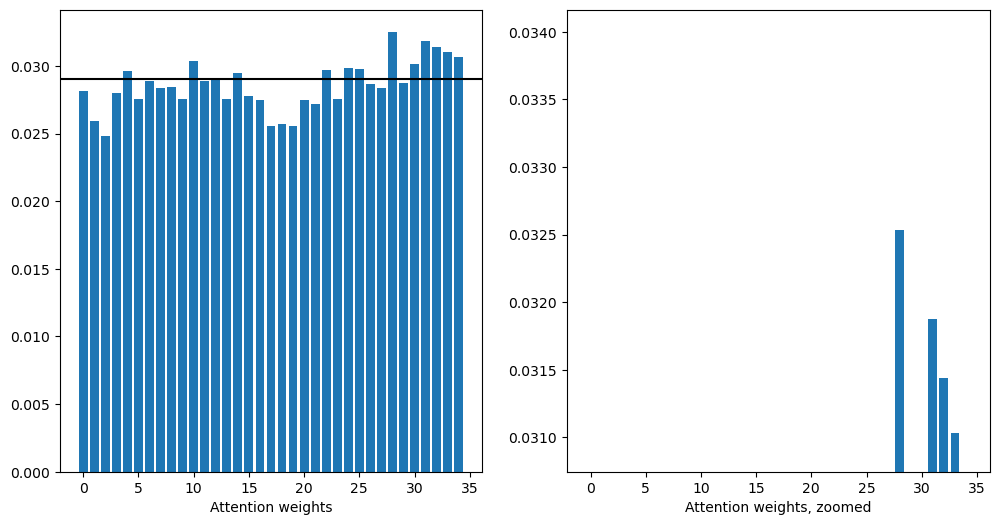

In [30]:
attention_slice = attention_weights[0, 0].numpy()
attention_slice = attention_slice[attention_slice != 0]

plt.suptitle('Attention weights for one sequence')

plt.figure(figsize=(12, 6))
a1 = plt.subplot(1, 2, 1)
plt.bar(range(len(attention_slice)), attention_slice)
# freeze the xlim
plt.xlim(plt.xlim())
plt.xlabel('Attention weights')

a2 = plt.subplot(1, 2, 2)
plt.bar(range(len(attention_slice)), attention_slice)
plt.xlabel('Attention weights, zoomed')

# zoom in
top = max(a1.get_ylim())
zoom = 0.85*top
a2.set_ylim([0.90*top, top])
a1.plot(a1.get_xlim(), [zoom, zoom], color='k')

plt.show()

## 3.3 POS TAGS

In [ ]:
pos_example_batch = []
np_inputs = example_context_batch.numpy()
for batch in np_inputs:
  batch_phrase = []
  for word in batch:
    w = dataset_creator.tokenizer_context.sequences_to_texts([[word]])
    token = nlp(w[0])
    batch_phrase.append(pos_dict[token[0].pos_])
  pos_example_batch.append(batch_phrase)

encoder_outputs, encoder_state = encoder((example_context_batch,
                                          tf.convert_to_tensor(pos_example_batch)
                                          ))

In [ ]:
sampled_tokens = tf.random.categorical(
    logits=decoder_logits[:, 0, :],
    # num_samples=1,
    seed=dataset_config['random_seed'])
vocab = np.array(list(word_to_idx_question[2].keys()))

samples = sampled_tokens.numpy()
pos_sampled_tokens = tf.constant([[pos_dict[nlp(dataset_creator.tokenizer_question.sequences_to_texts([samples[i]])[0])[0].pos_]]
                              for i in range(dataset_config['batch_size'])])

decoder_logits, _, _ = decoder([sampled_tokens,pos_sampled_tokens, encoder_outputs], state=decoder_state)

# 4. Question Generation Model

In this section we will build the model used for training.

## 4.1 Tensorboard initialization

Remember to clear any logs from previous runs.

In [31]:
!rm -rf ./logs/

Set up summary writers to write the summaries to disk in a different logs directory.

In [32]:
log_dir = './logs'

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = log_dir + '/gradient_tape/' + current_time + '/train'
test_log_dir = log_dir + '/gradient_tape/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

## 4.2 Loss

The **QG** task is defined as finding $\hat{y}$ such that:
$$
\hat{y} = \arg{\max_y P(y|x)}  
$$
where $P(y|x)$ is the conditional log-likelihood of the predicted question sentence $y$ given the input $x$. Du et al. shown that the conditional probability could be factorized in:
$$
P(y|x) = \prod_{t=1}^{|y|} P(y_t|x, y_{<t})
$$
where the probability of each $y_t$ is predicted based on all the words that have been generated upon time $t$, namely $y_{<t}$.

This means that given a training corpus of sentence-question pairs $\mathcal{S} = \{(x^{(i)}, y^{(i)})\}_{i=1}^N$, the objective is to minimize the negative log-likelihood:
$$
\begin{align*}
\mathcal{L} &= - \sum_{i=1}^N \log P(y^{(i)}|x^{(i)}; \theta)\\
            &=  - \sum_{i=1}^N \sum_{j=1}^{|y^{(i)}|} \log P (y_j^{(i)}|x^{(i)}, y_{<j}^{(i)}; \theta)
\end{align*}
$$
We parameterize the probability of decoding each word $y_j$ by using an RNN:
$$
P(y_j|y_{<j}, s) = \text{softmax}(g(h_j))
$$
where $g(.)$ is a transition function that outputs a vocabulary-sized vector.

For more information see [here](https://stackoverflow.com/questions/47057361/how-do-i-mask-a-loss-function-in-keras-with-the-tensorflow-backend) and in the `src.models.loss.py` file.

## 4.3 Training metrics

The metrics used during training will be:
1. **perplexity**, that is defined as $e^{H(p,q)}$ where $H(p,q)$ is the cross-entropy between $p$, that is the ground truth (labels), and $q$, that are unscaled probabilities distributions (logits), 
2. **masked accuracy**, namely an accuracy computed only on tokens which are not `<pad>`.

They will be implemented by exploiting the `Metric` object in `tensorflow`. See [here](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Metric) for more. The implementation is in `src.models.trainers.metrics.py`.

## 4.4 Callbacks

In [33]:
# Initialize the callbacks
batch_loss = BatchLogs('batch_loss')
perplexity = BatchLogs('perplexity')
accuracy = BatchLogs('accuracy')
lr_scheduler = CustomLearningRateScheduler()
epoch_counter = GetEpochNumber()
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_perplexity', 
                                                  patience=3, 
                                                  mode='min', 
                                                  restore_best_weights=True) 

## 4.5 Trainer Model definition

The training step should:
1. Run the encoder on the `input_tokens` to get the `encoder_outputs`, `hidden_state` and `cell_state`. 

... complete

In [34]:
from src.models.trainers.trainer import Trainer

# Utility function in order to build the compiled model
def build_model(model_config,
                embedding_matrix_context,
                embedding_matrix_question,
                compile_info):
  print("Model Configuration \nParameters: {}".format(model_config))
  print("Compile \nParameters: {}".format(compile_info))
  model = Trainer(model_config,
                  embedding_matrix_context=embedding_matrix_context,
                  embedding_matrix_question=embedding_matrix_question)

  model.compile(**compile_info)
  return model

def train_model(model,
                dataset: NamedTuple,
                training_info):
    """
    Training routine for the Keras model.
    At the end of the training, retrieved History data is shown.

    :param model: Keras built model
    :param dataset: the split dataset
    :param training_info: dictionary storing model fit() argument information

    :return
        model: trained Keras model
    """
    print("Start training \nParameters: {}".format(training_info))
    history = model.fit(dataset.train,
                        validation_data=dataset.val,
                        use_multiprocessing=True,
                        **training_info)
    print("Training completed")
    return history, model

# 5. Train the model

## 5.1 Keras Tuner 

In [36]:
import keras_tuner as kt

if ENABLE_KERAS_TUNER:
  # Max epochs for the KerasTuner
  epochs_tuning = 20

  # Batch size used

  # tune the hyperparameters of the possible choices
  tuner = kt.Hyperband(lambda hp: build_model(embedding_matrix_context=embedding_matrix_context,
                                              embedding_matrix_question=embedding_matrix_question,
                                              model_config={
                                                  'batch_size': hp.Choice('batch_size', [128]),
                                                  "dropout_rate": hp.Choice('dropout_rate', [0.3]),
                                                  "regularizer": hp.Choice("regularizer", [1e-2, 1e-3]),
                                                  "enc_units":  hp.Choice('units', [150, 300]),
                                                  "dec_units": hp.Choice('units', [150, 300]),
                                                  'max_length_context': dataset.train.element_spec[0].shape[1],
                                                  'max_length_question': dataset.train.element_spec[1].shape[1],
                                              },
                                              compile_info={
                                                  'loss': MaskedLoss(),
                                                  'optimizer': keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [1e-3, 5e-4, 1e-4])),  
                                              }),
                      objective=kt.Objective("val_perplexity", direction="min"),
                      max_epochs=epochs_tuning,
                      overwrite=True,
                      directory="tuner",
                      project_name="tuner_qg"
                      )

  tuner.search_space_summary()

  #stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, mode="max", restore_best_weights=True)

  tuner.search( dataset.train,
                validation_data = dataset.val,
                epochs=epochs_tuning,
                callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_perplexity',
                                                  patience=5,
                                                  mode='max',
                                                  restore_best_weights=True)] )
  best_hps = tuner.get_best_hyperparameters()[0]

  print(f"The hyperparameter search is complete.\n"
        f"The optimal regualizer rate is: {best_hps.get('batch_size')}.\n"
        f"The optimal regualizer rate is: {best_hps.get('regularizer')}.\n"
        f"The optimal rate for Dropout layer is: {best_hps.get('dropout_rate')}.\n"
        f"The optimal number of units is: {best_hps.get('enc_units')}.\n"
        f"The optimal learning rate for the optimizer is: {best_hps.get('learning_rate')}.")

## 5.2 Fine Tuning

In [44]:
# Those should go into the configuration file

training_info = {
    'verbose': 1,
    'epochs': 20,
    'batch_size': dataset_config['batch_size'],
    'callbacks': [
                  batch_loss,
                  perplexity,
                  accuracy,
                  # lr_scheduler,
                  # tensorboard_callback,
                  # epoch_counter,
                  early_stopping
                  ],
}

model_config = {
    'batch_size': dataset_config['batch_size'],
    'enc_units': 256,
    'dec_units': 256,
    'max_length_context': dataset_creator.max_length_context,
    'max_length_question': dataset_creator.max_length_question,
    'dropout_rate': 0.3,
    'regularizer': 1e-2,
}

compile_info = {
    'loss': MaskedLoss(),
    'optimizer': keras.optimizers.Adam(learning_rate=1e-5)}

In [45]:
if not ENABLE_KERAS_TUNER:
  qg_model = build_model(model_config, embedding_matrix_context, embedding_matrix_question, compile_info)
  history, qg_model = train_model(model=qg_model, dataset=dataset, training_info=training_info)

Model Configuration 
Parameters: {'batch_size': 32, 'enc_units': 256, 'dec_units': 256, 'max_length_context': 102, 'max_length_question': 27, 'dropout_rate': 0.3, 'regularizer': 0.01}
Compile 
Parameters: {'loss': <src.models.loss.MaskedLoss object at 0x000002270FF8BE50>, 'optimizer': <keras.optimizers.optimizer_v2.adam.Adam object at 0x000002270FF8B940>}
Start training 
Parameters: {'verbose': 1, 'epochs': 20, 'batch_size': 32, 'callbacks': [<src.models.callbacks.BatchLogs object at 0x000002267E0D70A0>, <src.models.callbacks.BatchLogs object at 0x000002265FAB2770>, <src.models.callbacks.BatchLogs object at 0x000002267E0D79D0>, <keras.callbacks.EarlyStopping object at 0x000002267E0D7580>]}
Epoch 1/20
1823/1823 [==============================] - 5061s 3s/step - loss: 5.8059 - accuracy: 0.0807 - perplexity: 332.2460 - masked_accuracy: 0.1356 - val_loss: 5.6868 - val_accuracy: 0.0808 - val_perplexity: 294.9524 - val_masked_accuracy: 0.1496
Epoch 2/20
1443/1823 [======================>....

KeyboardInterrupt: 

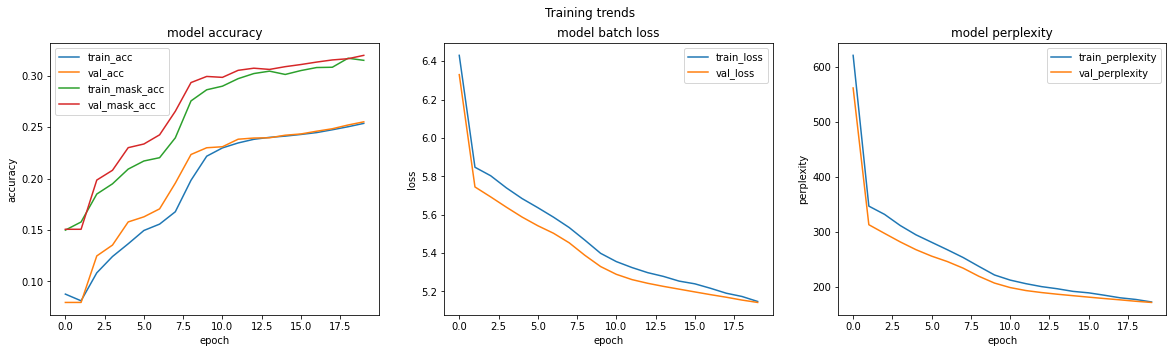

In [57]:
def plot_history(hist):
    fig, axs = plt.subplots(1, 3, figsize=(20,5))

    fig.suptitle('Training trends')
    axs[0].plot(hist.history['accuracy'])
    axs[0].plot(hist.history['val_accuracy'])
    axs[0].plot(hist.history['masked_accuracy'])
    axs[0].plot(hist.history['val_masked_accuracy'])
    axs[0].set_title("model accuracy")
    axs[0].set_ylabel('accuracy')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train_acc', 'val_acc', 'train_mask_acc', 'val_mask_acc'], loc='best')

    axs[1].plot(hist.history['loss'])
    axs[1].plot(hist.history['val_loss'])
    axs[1].set_title("model batch loss")
    axs[1].set_ylabel('loss')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train_loss', 'val_loss'], loc='best')

    axs[2].plot(hist.history['perplexity'])
    axs[2].plot(hist.history['val_perplexity'])
    axs[2].set_title("model perplexity")
    axs[2].set_ylabel('perplexity')
    axs[2].set_xlabel('epoch')
    axs[2].legend(['train_perplexity', 'val_perplexity'], loc='best')

    plt.show()

plot_history(history)                                                                                                                                                                        

In [58]:
qg_model.save_weights('./training_checkpoints/weights_run_opt')

In [59]:
#%tensorboard --logdir ./logs/gradient_tape

# 6. Inference and Evaluation for QG


## 6.1 Evaluation metrics

To evaluate our model we will use the **ROUGE-$n$**, **ROUGE-L** and **METEOR** metrics imported from [Hugginface](https://huggingface.co/datasets)([github/datasets](https://github.com/huggingface/datasets/tree/master/metrics)). For more information the single metrics please refer to the official [repository](https://github.com/huggingface/datasets/tree/master/metrics).



In [60]:
from datasets import load_metric

class METEOR(keras.metrics.Metric):
  def __init__(self, name=f"meteor_metric", **kwargs):
    """
    Initialize the metric object for computing METEOR.
    """
    super(METEOR, self).__init__(name=name, **kwargs)
    # Reference :- https://github.com/huggingface/datasets/tree/master/metrics/meteor
    self.meteor = load_metric("meteor")
    self.scores = self.add_weight(name=f"meteor_scores", initializer="zeros", dtype=tf.float64)

  def update_state(self, y_true, y_pred, sample_weight=None):
    results = self.meteor.compute(predictions=y_pred, references=y_true)
    self.scores.assign(tf.constant(results['meteor'], dtype=tf.float64))

  def result(self):
    return {'meteor': self.scores}

  def reset_state(self):
    # The state of the metric will be reset at the start of each epoch.
    self.scores.assign(0.0)

class ROUGE(keras.metrics.Metric):
  def __init__(self, name=f"rouge_metric", **kwargs):
    """
    Initialize the metric object for computing ROUGE.
    """
    super(ROUGE, self).__init__(name=name, **kwargs)
    # Reference :- https://github.com/huggingface/datasets/tree/master/metrics/rouge
    self.rouge = load_metric("rouge")

    self.precision_1 = self.add_weight(name=f"rouge1_precision_scores", initializer="zeros")
    self.recall_1 = self.add_weight(name=f"rouge1_recall_scores", initializer="zeros")
    self.fmeasure_1 = self.add_weight(name=f"rouge1_fmeasure_scores", initializer="zeros")

    self.precision_2 = self.add_weight(name=f"rouge2_precision_scores", initializer="zeros")
    self.recall_2 = self.add_weight(name=f"rouge2_recall_scores", initializer="zeros")
    self.fmeasure_2 = self.add_weight(name=f"rouge2_fmeasure_scores", initializer="zeros")

    self.precisionL = self.add_weight(name=f"rougeL_precision_scores", initializer="zeros")
    self.recallL = self.add_weight(name=f"rougeL_recall_scores", initializer="zeros")
    self.fmeasureL = self.add_weight(name=f"rougeL_fmeasure_scores", initializer="zeros")

  def update_state(self, y_true, y_pred, sample_weight=None):
    results = self.rouge.compute(predictions=y_pred, references=y_true, rouge_types=['rouge1', 'rouge2', 'rougeL'], use_aggregator=True)

    self.precision_1.assign(tf.constant(results['rouge1'].mid.precision, dtype=tf.float32))
    self.recall_1.assign(tf.constant(results['rouge1'].mid.recall, dtype=tf.float32))
    self.fmeasure_1.assign(tf.constant(results['rouge1'].mid.fmeasure, dtype=tf.float32))

    self.precision_2.assign(tf.constant(results['rouge2'].mid.precision, dtype=tf.float32))
    self.recall_2.assign(tf.constant(results['rouge2'].mid.recall, dtype=tf.float32))
    self.fmeasure_2.assign(tf.constant(results['rouge2'].mid.fmeasure, dtype=tf.float32))

    self.precisionL.assign(tf.constant(results['rougeL'].mid.precision, dtype=tf.float32))
    self.recallL.assign(tf.constant(results['rougeL'].mid.recall, dtype=tf.float32))
    self.fmeasureL.assign(tf.constant(results['rougeL'].mid.fmeasure, dtype=tf.float32))

  def result(self):
    return {'precision_1': self.precision_1,
            'recall_1': self.recall_1,
            'fmeasure_1': self.fmeasure_1,
            'precision_2': self.precision_2,
            'recall_2': self.recall_2,
            'fmeasure_2': self.fmeasure_2,
            'precisionL': self.precisionL,
            'recallL': self.recallL,
            'fmeasureL': self.fmeasureL}

  def reset_state(self):
    # The state of the metric will be reset at the start of each epoch.
    self.precision_1.assign(0.0)
    self.recall_1.assign(0.0)
    self.fmeasure_1.assign(0.0)

    self.precision_2.assign(0.0)
    self.recall_2.assign(0.0)
    self.fmeasure_2.assign(0.0)

    self.precisionL.assign(0.0)
    self.recallL.assign(0.0)
    self.fmeasureL.assign(0.0)

class AnswerabilityMetric(keras.metrics.Metric):
  def __init__(self, **kwargs):
    """
    Initialize the metric object for computing Answerability.
    """
    super(AnswerabilityMetric, self).__init__(**kwargs)
    self.nlp = spacy.load('en_core_web_sm')
    self.scores = self.add_weight(name = f"answerability", initializer= "zeros")

  def update_state(self, y_pred, y_true, metric_name=None, metric_value=None, alpha=0.7, sample_weight=None):
    if (metric_value == None or metric_name == None):
      value_answerability = self.batch_answerability_value(y_pred, y_true)
    else:
     value_answerability = self.q_metric(y_pred, y_true, metric_value, alpha) 
     self.scores = self.add_weight(name = f"answerability_{metric_name}", initializer= "zeros")
    self.scores.assign(value_answerability)

  def compute_ner(self,sentence):
    """Find the NER into the sentence"""
    doc = self.nlp(sentence)
    count = 0
    entities = []
    for ent in doc.ents:
      entities.append(str(ent))
    return entities
  
  # Find the question words into the sentence
  def question_words(self,sentence):
    question_words = []
    question_terms = ['what','where','when','whom','how','which','whose','why','?']
    for q in question_terms:
      if(q in sentence):
        question_words.append(q)
    return question_words

  # Extract the keyword based on the POS
  def get_keywords(self,text):
    hotwords = []
    pos_tag = ['PROPN', 'ADJ', 'NOUN']
    doc = self.nlp(text) # 2
    for token in doc:
        if(token.text in self.nlp.Defaults.stop_words):
            continue
        if(token.pos_ in pos_tag):
            hotwords.append(token.text)
    return hotwords

  #Extraction of context words using keywords extraction by spaCy
  def extract_context_word(self,sentence):
    numOfKeywords = len(sentence)
    context_words = []
    keywords= self.get_keywords(sentence)
    for kw in keywords:
      context_words.append(kw)
    return context_words

  #Extraction of function words using stopwords extraction by spaCy
  def function_words(self,sentence):
    function_words = []
    stopwords = self.nlp.Defaults.stop_words
    for q in list(stopwords):
      if(q in sentence):
        function_words.append(q)
    return function_words

  def answerability_value (self, pred, truth, weights = [0.25, 0.25, 0.25]):
    if(type(pred)== list):
        pred = " ".join(pred)
    if(type(truth)== list):
      truth = " ".join(truth)
    #Set the weights
    w_relevant, w_ner, w_question = weights

    #Find the relevant words of truth and prediction
    truth_relevant = self.extract_context_word(truth)
    pred_relevant = self.extract_context_word(pred)
    #Calculate the count of matching words
    C_relevant = len([w for w in truth_relevant if w in pred_relevant])
    #If no relevant words the weight is reduced to 0
    if (len(truth_relevant)==0 and len(pred_relevant)==0):
      w_relevant=0
      
    #Find NER of truth and prediction
    truth_ner = self.compute_ner(truth)
    pred_ner = self.compute_ner(pred)
    #Calculate the count of matching words
    C_ner = len([w for w in truth_ner if w in pred_ner])
    #If no NER words the weight is reduced to 0
    if (len(truth_ner)==0 and len(pred_ner)==0):
      w_ner=0 

    #Find question words in truth and pred
    truth_question = self.question_words(truth)
    pred_question = self.question_words(pred)
    #Calculate the count of matching words
    C_question = len([w for w in truth_question if w in pred_question])
    #If no question words the weight is reduced to 0
    if (len(truth_question)==0 and len(pred_question)==0):
      w_question=0

    #Find functional words as the rest of the words excluding the already counted
    truth_functional = self.function_words(truth)
    pred_functional = self.function_words(pred)
    w_functional = 1 - (w_relevant+ w_ner+ w_question)

    C_functional = len([w for w in truth_functional if w in pred_functional])

    #Calculate precision and recall
    P = w_relevant*C_relevant/(len(pred_relevant)+1e-10) + w_ner*C_ner/(len(pred_ner)+1e-10) + w_question*C_question/(len(pred_question)+1e-10) + w_functional*C_functional/(len(pred_functional)+1e-10)
    R = w_relevant*C_relevant/(len(truth_relevant)+1e-10) + w_ner*C_ner/(len(truth_ner)+1e-10) + w_question*C_question/(len(truth_question)+1e-10) + w_functional*C_functional/(len(truth_functional)+1e-10)
    
    #Compute final answerability value
    answerability = 2 * P * R / (P + R + 1e-10)

    return answerability

  #Find the mean answerability value of a batch
  def batch_answerability_value(self, batch_pred, batch_truth):
    answ_values = []
    for i in range(len(batch_pred)):
        answ_values.append(self.answerability_value(list(batch_pred[i]),batch_truth[i]))
    batch_answ = tf.reduce_mean(answ_values)

    return batch_answ

  def q_metric(self,batch_pred,batch_truth,metric_value,alpha):
    answ = self.batch_answerability_value(batch_pred,batch_truth).numpy()
    m = metric_value.numpy()
    return tf.constant(alpha*(answ) + (1-alpha)*(m),dtype=tf.float32)

  def result(self): return self.scores
  def reset_state(self): self.scores.assign(0)

## 6.2 Evaluation and Inference
In this section we will provide the class and the methods for the evaluation and inference part.

In [61]:
class QuestionGenerator(tf.Module):
  def __init__(self, model, evaluation_config, tokenizer_context, tokenizer_question):
    self.model = model
    self.encoder = model.encoder
    self.decoder = model.decoder

    self.tokenizer_context = tokenizer_context
    # The tokenizer will be used for the conversion from question tokens to
    # strings. It requires the tokenizer fit on the questions. 
    self.tokenizer_question = tokenizer_question
   
    self.result_tokens = None   # Tokens predicted
    self.result_text = None     # Text predicted
    self.token_mask = self.create_mask()  # Mask for the tokens

    self.start_idx = tokenizer_question.word_index['<sos>']
    self.end_idx = tokenizer_question.word_index['<eos>']
    self.unk_idx = tokenizer_question.word_index['<unk>']

    # Config
    self.temperature = evaluation_config['temperature']

    # Metrics
    # These ones are computed and refreshed for each batch
    self.meteor_metric_batch = METEOR()
    self.rouge_metric_batch = ROUGE()
    self.answerability_metric = AnswerabilityMetric()
    
    # These ones are the mean value among all the batches
    self.meteor_metric = tf.keras.metrics.Mean(name='meteor_mean')
    self.rouge1_precision_metric = tf.keras.metrics.Mean(name='rouge1_precision_mean')
    self.rouge1_recall_metric = tf.keras.metrics.Mean(name='rouge1_recall_mean')
    self.rouge1_fmeasure_metric = tf.keras.metrics.Mean(name='rouge1_fmeasure_mean')
    self.rouge2_precision_metric = tf.keras.metrics.Mean(name='rouge2_precision_mean')
    self.rouge2_recall_metric = tf.keras.metrics.Mean(name='rouge2_recall_mean')
    self.rouge2_fmeasure_metric = tf.keras.metrics.Mean(name='rouge2_fmeasure_mean')
    self.rougeL_precision_metric = tf.keras.metrics.Mean(name='rougeL_precision_mean')
    self.rougeL_recall_metric = tf.keras.metrics.Mean(name='rougeL_recall_mean')
    self.rougeL_fmeasure_metric = tf.keras.metrics.Mean(name='rougeL_fmeasure_mean')

    # Store evaluation results
    self.results = dict()
    self.results_answerability = dict()

  def token_to_string(self, result_tokens: tf.Tensor):  
    """
    This method converts token IDs to text by using a given mapping.
    """
    list_tokens = result_tokens.numpy().tolist()
    list_text = self.tokenizer_question.sequences_to_texts(list_tokens)
    
    # list_text = tf.convert_to_tensor([list_text])
    # result_text = tf.strings.reduce_join(list_text, axis=0, separator=' ')
    # result_text = tf.strings.strip(result_text)
    result_text = [s.split() for s in list_text]

    self.result_tokens = result_tokens
    self.result_text = result_text
    return result_text
  
  def create_mask(self):
    """
    This method creates a mask for the padding, the unknwon words and the start/ending tokens.
    """
    masked_words = ['<pad>', '<sos>', '<eos>']
    token_mask_ids = [self.tokenizer_question.word_index[mask] for mask in masked_words]

    token_mask = np.zeros(shape=(len(self.tokenizer_question.word_index),), dtype=bool)
    token_mask[np.array(token_mask_ids)] = True
    return token_mask

  def remove_tags(self, result_tokens: tf.Tensor):
    """
    This method removes the padding, start and end of sentence tags
    """
    list_tokens = result_tokens.numpy().tolist()
    tag_words = ['<pad>', '<sos>', '<eos>']
    token_tag_ids = [self.tokenizer_question.word_index[tag] for tag in tag_words]
    
    #For every element of the batch we extract the token list and we remove the unwanted tokens
    list_tokens = [[token for token in token_list if token not in token_tag_ids] for token_list in list_tokens]
    
    texts = self.tokenizer_question.sequences_to_texts(list_tokens)
    texts = [s.split() for s in texts]

    return texts

  @tf.autograph.experimental.do_not_convert 
  def evaluate_metric_answerability(self, inputs, max_length, metric_name=None, metric_value=None):
    """
    """
    self.answerability_metric.reset_state()
    
    seq = []
    for (context, question_true) in tqdm(inputs):
      question_true = self.remove_tags(question_true)
      prediction = self.predict_step(inputs=context, 
                                     max_length=max_length, 
                                     return_attention=False, 
                                     pretty_predict=False)
      
      question_pred = prediction['text']

      # Compute answerability weighted score on the given metric chosen
      self.answerability_metric.update_state(y_pred=question_pred, y_true=question_true, metric_name=metric_name, metric_value=tf.constant(metric_value))
      seq.append(self.answerability_metric.result())
    
    self.results_answerability[f'{metric_name}'] = tf.reduce_mean(seq).numpy()
    return self.results_answerability
    
  @tf.autograph.experimental.do_not_convert 
  def evaluate(self, inputs, max_length):
    self.meteor_metric.reset_state()
    self.rouge1_precision_metric.reset_state()
    self.rouge1_recall_metric.reset_state()
    self.rouge1_fmeasure_metric.reset_state()
    self.rouge2_precision_metric.reset_state()
    self.rouge2_recall_metric.reset_state()
    self.rouge2_fmeasure_metric.reset_state()
    self.rougeL_precision_metric.reset_state()
    self.rougeL_recall_metric.reset_state()
    self.rougeL_fmeasure_metric.reset_state()

    for (context, question_true) in tqdm(inputs):
      self.meteor_metric_batch.reset_state()
      self.rouge_metric_batch.reset_state()

      question_true = self.remove_tags(question_true)
      prediction = self.predict_step(inputs=context, max_length=max_length, return_attention=False, pretty_predict=False)
      question_pred = prediction['text']

      # Compute the metric for the current batch
      self.meteor_metric_batch.update_state(y_true=question_true, y_pred=question_pred)
      # Compute the mean over the batches
      self.meteor_metric.update_state(self.meteor_metric_batch.result()['meteor'])

      # Compute for the current batch
      self.rouge_metric_batch.update_state(y_true=question_true, y_pred=question_pred)
      # Compute the mean over the batches
      self.rouge1_precision_metric.update_state(self.rouge_metric_batch.result()['precision_1'])
      self.rouge1_recall_metric.update_state(self.rouge_metric_batch.result()['recall_1'])
      self.rouge1_fmeasure_metric.update_state(self.rouge_metric_batch.result()['fmeasure_1'])
      self.rouge2_precision_metric.update_state(self.rouge_metric_batch.result()['precision_2'])
      self.rouge2_recall_metric.update_state(self.rouge_metric_batch.result()['recall_2'])
      self.rouge2_fmeasure_metric.update_state(self.rouge_metric_batch.result()['fmeasure_2'])
      self.rougeL_precision_metric.update_state(self.rouge_metric_batch.result()['precisionL'])
      self.rougeL_recall_metric.update_state(self.rouge_metric_batch.result()['recallL'])
      self.rougeL_fmeasure_metric.update_state(self.rouge_metric_batch.result()['fmeasureL'])

      print()
      # print('METEOR batch', self.meteor_metric_batch.result())
      # print('ROUGE batch', self.rouge_metric_batch.result())

    self.results = {'METEOR': self.meteor_metric.result().numpy(),
            'ROUGE_1_PRECISION': self.rouge1_precision_metric.result().numpy(),
            'ROUGE_1_RECALL': self.rouge1_recall_metric.result().numpy(),
            'ROUGE_1_FMEASURE': self.rouge1_fmeasure_metric.result().numpy(),
            'ROUGE_2_PRECISION': self.rouge2_precision_metric.result().numpy(),
            'ROUGE_2_RECALL': self.rouge2_recall_metric.result().numpy(),
            'ROUGE_2_FMEASURE': self.rouge2_fmeasure_metric.result().numpy(),
            'ROUGE_L_PRECISION': self.rougeL_precision_metric.result().numpy(),
            'ROUGE_L_RECALL': self.rougeL_recall_metric.result().numpy(),
            'ROUGE_L_FMEASURE': self.rougeL_fmeasure_metric.result().numpy()}
    return self.results

  def predict(self, inputs, max_length, return_attention=False, pretty_predict=False):
    """
    Generates output predictions for the input samples.
    In addition it could also return the associated attention weights.

    It returns a list of dictionaries.
    """
    results = []
    for (context, _) in tqdm(inputs):
      results.append(self.predict_step(inputs=context, 
                                       max_length=max_length, 
                                       return_attention=return_attention,
                                       pretty_predict=pretty_predict))

    return results

  def predict_step(self, inputs, max_length, return_attention, pretty_predict):
    # Similarly for what it has been done in the train step
    encoder_output, encoder_state = self.encoder(inputs)
    decoder_state = encoder_state

    # Generate the first token of each sentence, that is the <sos> token
    new_token = tf.fill([self.model.batch_size, 1], self.start_idx)

    result_tokens = []
    attention = []

    done = tf.zeros(shape=(self.model.batch_size, 1), dtype=tf.bool)
    unk = tf.zeros(shape=(self.model.batch_size, 1), dtype=tf.bool)
    
    for _ in range(max_length):
      # Decode the token at the next timestep
      decoder_logits, attention_weights, decoder_state = self.decoder([new_token, encoder_output], state=decoder_state)
      
      attention.append(attention_weights)

      # Sample the new token accordingly to the distribution produced by the decoder
      new_token = self.temperature_sampling(decoder_logits)

      # if a sequence has reached <eos> set it as done
      done = done | (new_token == self.end_idx)
      # Once a sequence is done it only produces 0-padding.
      new_token = tf.where(done, tf.constant(0, dtype=tf.int64), new_token)

      # if a token produce has value <unk> set it as unk
      unk = unk | (new_token == self.unk_idx)
      # Once a token has been tagged as unk we have to chenage its value with 
      # the value in the context that has the highest attention
      highest_attention = tf.math.argmax(attention_weights, axis=-1)
      context_attention = tf.gather(inputs, highest_attention, axis=-1, batch_dims=1)
      new_token = tf.where(unk, context_attention, new_token)

      result_tokens.append(new_token)

      if tf.reduce_all(done):
        break

    result_tokens = tf.concat(result_tokens, axis=-1)
    result_text = self.token_to_string(result_tokens)
    if pretty_predict: result_text = self.prettify(result_text)

    attention_stack = tf.concat(attention, axis=-1)

    if return_attention:
      attention_stack = tf.concat(attention, axis=1)
      return {'text': result_text, 'attention': attention_stack}
    else:
      return {'text': result_text}

  def prettify(self, result_text):
    results = []
    for sen in result_text:
      results.append(" ".join(list(sen)))
    return results

  def temperature_sampling(self, logits):
    """
    For the temperature choice see here:
      Reference :- https://nlp.stanford.edu/blog/maximum-likelihood-decoding-with-rnns-the-good-the-bad-and-the-ugly/
    """
    # First of all we use broadcast the generated mask to the expected logits' shape
    # token_mask shape: (batch_size, timestep, vocab_size)
    token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]

    # The logits for all the tokens that have to not be used are set to -1.0
    logits = tf.where(token_mask, -1.0, logits)

    # Freezing function
    # Higher temperature -> greater variety
    # Lower temperature -> grammatically correct
    if self.temperature == 0.0:
      # the freezing function is the argmax, behaving like a greedy search
      new_token = tf.argmax(logits, axis=-1)
    else:
      # the freezing function now scales the logits.
      # for temperature == 1.0 is the identity function
      logits = tf.squeeze(logits, axis=1)
      new_token = tf.random.categorical(logits / self.temperature, num_samples=1)
    return new_token

  def show(self, inputs, max_length, complete_tokenizer, max_q):
    batch_idx = random.randint(1, inputs.cardinality())
    predictions = self.predict_step(inputs.batch(batch_idx)[0], max_length, False, True)
    predictions = predictions.numpy().tolist()
    predictions = predictions[0][:max_q]
    print(predictions)
    for i, (context, question) in enumerate(inputs.batch(batch_idx)):
      if i == 1: break
      question = question.numpy().tolist()
      references = question[0][:max_q]
      references = self.tokenizer_question.sequences_to_texts(references)

In [62]:
qg_evaluator = QuestionGenerator(model=qg_model, evaluation_config=evaluation_config, tokenizer_question=dataset_creator.tokenizer_question, tokenizer_context=dataset_creator.tokenizer_context)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [63]:
# qg_evaluator.show(dataset.test, 10, None, 5)

### 6.3.1 Inference

In this section we can compute the predictions with our pre-trained model. By using the `predict` method provided by the `Evaluator`class we can compute the predictions on the test set. Obviously only the context sentence will be used to this end.

In [64]:
%%time
predictions = qg_evaluator.predict(dataset.test, 20, False, True)

100%|██████████| 46/46 [00:26<00:00,  1.72it/s]

CPU times: user 21.9 s, sys: 1.1 s, total: 23 s
Wall time: 26.8 s


Then we can print out some of them, e.g, we print 10 questions that have been predicted for the first batch: 

In [86]:
#dataset_creator.tokenizer_question.sequences_to_texts((next(iter(dataset.test))[1][60:70].numpy()))

In [84]:
predictions[0]['text'][60:70]

['what was the the the the day the do of the the spoken ? to two ? in ? on',
 'who was the the the this the the all ? ? of the of the ? of where term ?',
 'what is the of type of the first the of the the to of of reception ? ? ? ?',
 'what was the the prominent types the the banned ? of it ? ? ? in ? ? of in',
 'what did did the the members to of he company ? in the the players ? ? ? ? ?',
 'what years the the the the helped a chinese ? his to group ? in the the military the the',
 'which did created was in the a ? in ? to the the for in the fit ? ? for',
 'when did the the red the namibia for i ? where ? to the the the <sos> <sos> <sos> <sos>',
 'what was the a of in an to do to the medieval ? ? ? ? to premier of the',
 'what was the the the victor the of of the the . used ? in of offer ? the the']

### 6.3.2 Evaluation 
In this section we can evaluate our model. For this reason we pass the testing split of the dataset. 

In [66]:
%%time 
evaluation_results = qg_evaluator.evaluate(dataset.test, 20)

  2%|▏         | 1/46 [00:08<06:04,  8.10s/it]

  4%|▍         | 2/46 [00:09<02:58,  4.06s/it]

  7%|▋         | 3/46 [00:10<01:57,  2.73s/it]

  9%|▊         | 4/46 [00:11<01:28,  2.11s/it]

 11%|█         | 5/46 [00:12<01:12,  1.76s/it]

 13%|█▎        | 6/46 [00:13<01:02,  1.55s/it]

 15%|█▌        | 7/46 [00:15<00:55,  1.42s/it]

 17%|█▋        | 8/46 [00:16<00:50,  1.34s/it]

 20%|█▉        | 9/46 [00:17<00:47,  1.29s/it]

 22%|██▏       | 10/46 [00:18<00:44,  1.25s/it]

 24%|██▍       | 11/46 [00:19<00:42,  1.21s/it]

 26%|██▌       | 12/46 [00:20<00:41,  1.21s/it]

 28%|██▊       | 13/46 [00:22<00:39,  1.20s/it]

 30%|███       | 14/46 [00:23<00:38,  1.19s/it]

 33%|███▎      | 15/46 [00:24<00:36,  1.18s/it]

 35%|███▍      | 16/46 [00:25<00:35,  1.18s/it]

 37%|███▋      | 17/46 [00:26<00:34,  1.17s/it]

 39%|███▉      | 18/46 [00:27<00:33,  1.18s/it]

 41%|████▏     | 19/46 [00:29<00:31,  1.17s/it]

 43%|████▎     | 20/46 [00:30<00:30,  1.16s/it]

 46%|████▌     | 21/46 [00:31<00:28,  1.16s/it]

 48%|████▊     | 22/46 [00:32<00:27,  1.16s/it]

 50%|█████     | 23/46 [00:33<00:26,  1.16s/it]

 52%|█████▏    | 24/46 [00:34<00:25,  1.16s/it]

 54%|█████▍    | 25/46 [00:36<00:24,  1.15s/it]

 57%|█████▋    | 26/46 [00:37<00:22,  1.15s/it]

 59%|█████▊    | 27/46 [00:38<00:21,  1.15s/it]

 61%|██████    | 28/46 [00:39<00:20,  1.15s/it]

 63%|██████▎   | 29/46 [00:40<00:19,  1.15s/it]

 65%|██████▌   | 30/46 [00:41<00:18,  1.16s/it]

 67%|██████▋   | 31/46 [00:42<00:17,  1.16s/it]

 70%|██████▉   | 32/46 [00:44<00:16,  1.16s/it]

 72%|███████▏  | 33/46 [00:45<00:15,  1.17s/it]

 74%|███████▍  | 34/46 [00:46<00:14,  1.17s/it]

 76%|███████▌  | 35/46 [00:47<00:12,  1.17s/it]

 78%|███████▊  | 36/46 [00:48<00:11,  1.17s/it]

 80%|████████  | 37/46 [00:49<00:10,  1.16s/it]

 83%|████████▎ | 38/46 [00:51<00:09,  1.16s/it]

 85%|████████▍ | 39/46 [00:52<00:08,  1.17s/it]

 87%|████████▋ | 40/46 [00:53<00:06,  1.17s/it]

 89%|████████▉ | 41/46 [00:54<00:05,  1.16s/it]

 91%|█████████▏| 42/46 [00:55<00:04,  1.16s/it]

 93%|█████████▎| 43/46 [00:56<00:03,  1.16s/it]

 96%|█████████▌| 44/46 [00:58<00:02,  1.15s/it]

 98%|█████████▊| 45/46 [00:59<00:01,  1.15s/it]

100%|██████████| 46/46 [01:00<00:00,  1.16s/it]

100%|██████████| 46/46 [01:21<00:00,  1.78s/it]

CPU times: user 58.7 s, sys: 448 ms, total: 59.1 s
Wall time: 1min 21s


Then we can check the results:

In [88]:
dict(evaluation_results)

{'METEOR': 0.4925994,
 'ROUGE_1_FMEASURE': 0.14209767,
 'ROUGE_1_PRECISION': 0.11734782,
 'ROUGE_1_RECALL': 0.1945316,
 'ROUGE_2_FMEASURE': 0.011932016,
 'ROUGE_2_PRECISION': 0.009749041,
 'ROUGE_2_RECALL': 0.016838448,
 'ROUGE_L_FMEASURE': 0.12943695,
 'ROUGE_L_PRECISION': 0.106331185,
 'ROUGE_L_RECALL': 0.17884359}

Also we can compute the respective Q-metrics for **METEOR** and **ROUGE-L**:

In [91]:
q_evaluation_result = qg_evaluator.evaluate_metric_answerability(dataset.test, 20, 'Q-METEOR', qg_evaluator.results['METEOR'])
q_evaluation_result = qg_evaluator.evaluate_metric_answerability(dataset.test, 20, 'Q-ROUGE_L_FMEASURE', qg_evaluator.results['ROUGE_L_FMEASURE'])

100%|██████████| 46/46 [06:21<00:00,  8.30s/it]


In [94]:
dict(q_evaluation_result)

{'Q-METEOR': 0.393617, 'Q-ROUGE_L_FMEASURE': 0.28519925}